# TECHSAS Magnetism processing notebook

### Imports

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime
import pyIGRF
import pyproj

### Methods

In [57]:
def compute_distance(longitudes: np.ndarray, latitudes: np.ndarray):
    """
    Returns an array with the distance between two consecutive positions
    """
    start_longitudes = longitudes[:-1]
    end_longitudes = longitudes[1:]
    start_latitudes = latitudes[:-1]
    end_latitudes = latitudes[1:]
    geodesic = pyproj.Geod(ellps="WGS84")
    _, _, distances = geodesic.inv(start_longitudes, start_latitudes, end_longitudes, end_latitudes)
    return distances

In [64]:
def apply_cable_out(longitudes: np.ndarray, latitudes: np.ndarray, cable_out: float) -> (
    np.ndarray, np.ndarray):
    # initialize new position
    new_longitudes = np.empty(longitudes.size)
    new_longitudes[:] = np.nan
    new_latitudes = np.empty(latitudes.size)
    new_latitudes[:] = np.nan

    #TODO : Time limit for location interpolation

    # compute dist between positions
    dists = compute_distance(longitudes, latitudes)

    for i in range(len(longitudes) - 1, -1, -1):
        # get position before and after cable out distance
        index_after = i  # start from current index
        index_before = i
        distance_before = 0
        distance_after = 0
        while distance_after < cable_out and index_after > 0:
            distance_before = distance_after
            distance_after += dists[index_after-1]
            index_before = index_after
            index_after -= 1

        # compute position at cable out distance by interpolation
        if distance_after > cable_out:
            coeff = (cable_out - distance_before) / (distance_after - distance_before)
            new_longitudes[i] = longitudes[index_before] + coeff * (longitudes[index_after] - longitudes[index_before])
            new_latitudes[i] = latitudes[index_before] + coeff * (latitudes[index_after] - latitudes[index_before])

    return new_longitudes, new_latitudes

In [60]:
def proccess_mag_file(mag_file_path : str , output_file_path: str, cable_out : float):
    """ TECHSAS magentism file processing : compute absolute gravity, eotvos, FAA... """
    
    with xr.open_dataset(mag_file_path) as ds:
        #ds = ds.sel(time=slice("2014-03-17 21", "2014-03-17 21:00:10"))
        lon = ds['lon'] #np.deg2rad(ds['lon']) # in radian
        lat = ds['lat'] #np.deg2rad(ds['lat']) # in radian
        
        # apply cable out
        lon.data, lat.data = apply_cable_out(lon.data,lat.data,cable_out)
        
        # compute theroetic magnetism with pyIGRF
        ds['theoretic_mag'] = xr.apply_ufunc(lambda lat, lon: pyIGRF.igrf_value(lat, lon, year=2014)[6], lat, lon, vectorize=True)

        # compute magnetic anomaly
        ds['magnetic_anomaly'] = ds['mag'] - ds['theoretic_mag']
        
        return ds
        #ds.to_netcdf(output_file_path)

---
### Tests

In [6]:
base_path = "C://Users//gbillant//Desktop//test_gravi//2014000700//"
mag_file = base_path + "201400070045-scalar_mag-AT_MAGSS.mag.nc"
mag_file_out = base_path + "201400070045-scalar_mag-AT_MAGSS_processed.mag.nc"
mag_file_ref = base_path + '201400070045-KSS-AT_KSS31M_processed_resampled.gravi.nc'

In [62]:
mag_file_processed = proccess_mag_file(mag_file,mag_file_out, 1000)
mag_file_processed
#gravi_file_resampled = gravi_file_processed.resample(time='60S').mean()
#gravi_file_resampled.to_netcdf(gravi_file.replace('.gravi.nc','_processed_resampled.gravi.nc'))

<xarray.Dataset>
Dimensions:           (time: 24213)
Coordinates:
  * time              (time) datetime64[ns] 2014-03-17T20:50:11.516639744 ......
Data variables:
    mag               (time) float32 ...
    depth             (time) float32 ...
    lon               (time) float64 nan nan nan nan ... -55.11 -55.11 -55.11
    lat               (time) float64 nan nan nan nan nan ... 11.1 11.1 11.1 11.1
    heading           (time) float64 ...
    speed             (time) float64 ...
    altitude          (time) float64 ...
    theoretic_mag     (time) float64 nan nan nan ... 3.183e+04 3.183e+04
    magnetic_anomaly  (time) float64 nan nan nan ... -9.197e+03 -9.478e+03
Attributes: (12/25)
    history:                       Mon Jul 21 15:43:36 2014: /home/coriolis_e...
    source:                        Acquisition of magnetometre
    conventions:                   CF-1.0.
    creationtime:                  2014-03-17T14:15:26Z
    device_firstusedate:           2000-01-01T00:00:00Z
    device_deviceid:               AT_MAGSS_006
    ...                            ...
    frame_sourcetype:              mag
    frame_period:                  10.0
    title:                         Technical and Scientific sensors Acquisiti...
    institution:                   IFR
    reference:                     http://www.ifremer.fr
    nco_openmp_thread_number:      1

In [25]:
mag_file_processed['lon'].data

array([-57.04850907, -57.04843995, -57.04836746, ..., -55.09955638,
       -55.0995352 , -55.0995114 ])

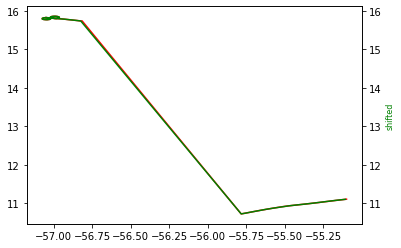

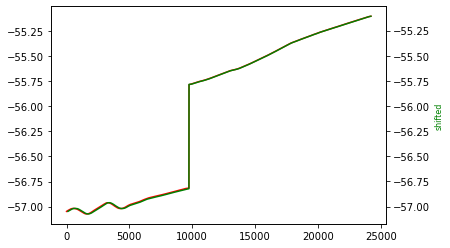

In [63]:
def plot_nav(ds1, ds2):
    #nav
    fig,ax = plt.subplots()
    ax.plot(ds1['lon'],ds1['lat'],color="red")
    ax2=ax.twinx()
    ax2.plot(ds2['lon'],ds2['lat'],'-',color="green")
    ax2.set_ylabel("shifted",color="green",fontsize=8)
    plt.show()

    fig,ax = plt.subplots()
    ax.plot(ds1['lon'],color="red")
    ax2=ax.twinx()
    ax2.plot(ds2['lon'],'-',color="green")
    ax2.set_ylabel("shifted",color="green",fontsize=8)
    plt.show()
    
    fig,ax = plt.subplots()
    ax.plot(ds1['lat'],color="red")
    ax2=ax.twinx()
    ax2.plot(ds2['lat'],'-',color="green")
    ax2.set_ylabel("shifted",color="green",fontsize=8)
    plt.show()
    
with xr.open_dataset(mag_file) as ds:
    plot_nav(ds,mag_file_processed)

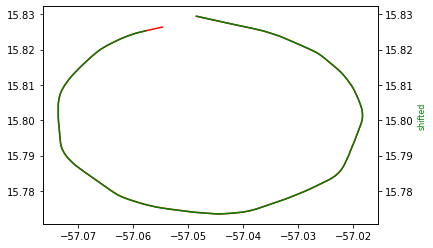

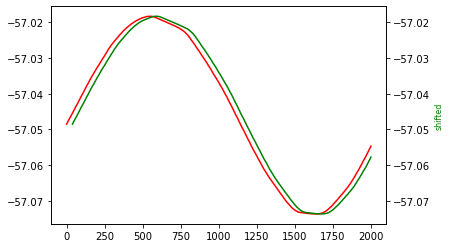

In [56]:
end = 2000
lon = mag_file_processed['lon'].data[:end]
lat = mag_file_processed['lat'].data[:end]
    
shift_lon, shift_lat = apply_cable_out(lon, lat, 350)

fig,ax = plt.subplots()
ax.plot(lon,lat,color="red")
ax2=ax.twinx()
ax2.plot(shift_lon,shift_lat,'-',color="green")
ax2.set_ylabel("shifted",color="green",fontsize=8)
plt.show()

fig,ax = plt.subplots()
ax.plot(lon,color="red")
ax2=ax.twinx()
ax2.plot(shift_lon,'-',color="green")
ax2.set_ylabel("shifted",color="green",fontsize=8)
plt.show()